# Time Series Analysis - AdEase

## About
Ad Ease is an ads and marketing based company helping businesses elicit maximum clicks @ minimum cost. AdEase is an ad infrastructure to help businesses promote themselves easily, effectively, and economically. The interplay of 3 AI modules - Design, Dispense, and Decipher, come together to make it this an end-to-end 3 step process digital advertising solution for all.

## Problem description
You are working in the Data Science team of Ad ease trying to understand the per page view report for different wikipedia pages for 550 days, and forecasting the number of views so that you can predict and optimize the ad placement for your clients. You are provided with the data of 145k wikipedia pages and daily view count for each of them. Your clients belong to different regions and need data on how their ads will perform on pages in different languages.

## Data
There are two csv files given

**train_1.csv**: In the csv file, each row corresponds to a particular article and each column corresponds to a particular date. The values are the number of visits on that date. The page name contains data in this format, having information about the page name, the main domain, the device type used to access the page, and also the request origin(spider or browser agent):<br>
SPECIFIC NAME _ LANGUAGE.wikipedia.org _ ACCESS TYPE _ ACCESS ORIGIN

**Exog_Campaign_eng**: This file contains data for the dates which had a campaign or significant event that could affect the views for that day. The data is just for pages in English. There’s 1 for dates with campaigns and 0 for remaining dates. It is to be treated as an exogenous variable for models when training and forecasting data for pages in English

In [89]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import re

from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae,
    mean_absolute_percentage_error as mape
)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
# importing the data
raw = pd.read_csv("data/train_1.csv")

In [3]:
raw.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [4]:
raw.shape

(145063, 551)

In [5]:
raw.duplicated().sum()

0

In [6]:
date_cols = list(raw.columns)
date_cols.remove('Page')

In [7]:
_ = raw.shape[0]
raw = raw.dropna(how='all',subset=date_cols)
print(f"{_-raw.shape[0]} rows removed out of {_}")

652 rows removed out of 145063


In [8]:
data = raw.melt(id_vars='Page', var_name='date', value_name='views')
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.sort_values(by='date', ascending=True).reset_index(drop=True)

In [9]:
data.head()

,Page,date,views
0,2NE1_zh.wikipedia.org_all-access_spider,2015-07-01,18.0
1,Síndrome_de_Guillain-Barré_es.wikipedia.org_mo...,2015-07-01,556.0
2,Organización_del_Tratado_del_Atlántico_Norte_e...,2015-07-01,55.0
3,Juego_de_tronos_(serie_de_televisión)_es.wikip...,2015-07-01,3202.0
4,Especial:LoQueEnlazaAquí_es.wikipedia.org_mobi...,2015-07-01,433.0


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79426050 entries, 0 to 79426049
Data columns (total 3 columns):
 #   Column  Dtype         
---  ------  -----         
 0   Page    object        
 1   date    datetime64[ns]
 2   views   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.8+ GB


In [11]:
data.isna().sum()

Page           0
date           0
views    5834331
dtype: int64

In [12]:
def fill_null_values(ser):
    filled_series = ser.interpolate().bfill().ffill()
    return filled_series

In [13]:
data['views'] = data.groupby('Page')['views'].transform(fill_null_values)

In [14]:
data['views'].isna().sum()

0

In [15]:
data.head()

,Page,date,views
0,2NE1_zh.wikipedia.org_all-access_spider,2015-07-01,18.0
1,Síndrome_de_Guillain-Barré_es.wikipedia.org_mo...,2015-07-01,556.0
2,Organización_del_Tratado_del_Atlántico_Norte_e...,2015-07-01,55.0
3,Juego_de_tronos_(serie_de_televisión)_es.wikip...,2015-07-01,3202.0
4,Especial:LoQueEnlazaAquí_es.wikipedia.org_mobi...,2015-07-01,433.0


### Feature extraction

In [16]:
data['Page'].head(5).values

array(['2NE1_zh.wikipedia.org_all-access_spider',
       'Síndrome_de_Guillain-Barré_es.wikipedia.org_mobile-web_all-agents',
       'Organización_del_Tratado_del_Atlántico_Norte_es.wikipedia.org_mobile-web_all-agents',
       'Juego_de_tronos_(serie_de_televisión)_es.wikipedia.org_mobile-web_all-agents',
       'Especial:LoQueEnlazaAquí_es.wikipedia.org_mobile-web_all-agents'],
      dtype=object)

In [17]:
# Define the regex pattern
regex = r"(?P<NAME>.+)_(?P<LANGUAGE>[a-z]{2})\.wikipedia\.org_(?P<ACCESS_TYPE>[a-z\-]+)_(?P<ACCESS_ORIGIN>[a-z\-]+)"

# create a dataframe with unique values of pages
unique_pages = pd.DataFrame(data=data['Page'].unique(), columns=['Page'])

# Create a new DataFrame to store the extracted features
features_df = unique_pages['Page'].str.extract(regex, expand=True)
features_df = pd.concat([unique_pages, features_df], axis=1)

# Add the extracted features as new columns to the original DataFrame
data = pd.merge(data, features_df, on='Page', how='left')
data = data.fillna("UNKNOWN").copy()


In [18]:
data.head()

,Page,date,views,NAME,LANGUAGE,ACCESS_TYPE,ACCESS_ORIGIN
0,2NE1_zh.wikipedia.org_all-access_spider,2015-07-01,18.0,2NE1,zh,all-access,spider
1,Síndrome_de_Guillain-Barré_es.wikipedia.org_mo...,2015-07-01,556.0,Síndrome_de_Guillain-Barré,es,mobile-web,all-agents
2,Organización_del_Tratado_del_Atlántico_Norte_e...,2015-07-01,55.0,Organización_del_Tratado_del_Atlántico_Norte,es,mobile-web,all-agents
3,Juego_de_tronos_(serie_de_televisión)_es.wikip...,2015-07-01,3202.0,Juego_de_tronos_(serie_de_televisión),es,mobile-web,all-agents
4,Especial:LoQueEnlazaAquí_es.wikipedia.org_mobi...,2015-07-01,433.0,Especial:LoQueEnlazaAquí,es,mobile-web,all-agents


In [19]:
data.to_csv("data/cleaned_data.csv", index=False)

The dataset size is 9.5GB, in order to reduce it, we will keep the pages which covers 90% of the views

In [20]:
page_views = data.groupby('Page').agg({'views': 'sum'})
views_90 = page_views['views'].quantile(0.9)
top_pages = page_views[page_views['views'] > views_90].index
data = data[data['Page'].isin(top_pages)].copy()

In [21]:
data.to_csv("data/reduced_data.csv", index=False)

Now the dataset size reduced to only 1GB

In [22]:
data.shape

(7942550, 7)

In [23]:
# reading the dataset back
data = pd.read_csv("data/reduced_data.csv")
data['date'] = pd.to_datetime(data['date'])

### Grouping the data for time series modeling

In [24]:
# we cannot use categorical features in our data since we will need one value corresponding to each date
# after grouping, we will add the exog variable
model_data = data.groupby('date').agg({'views': 'sum'}).reset_index()

In [25]:
# the exog file does not have dates included. So we will add the dates to the exog file using the data dataframe
significant_dates = pd.read_csv("data/Exog_Campaign_eng")
all_dates = pd.date_range(start=data['date'].min(), end=data['date'].max())
significant_dates['date'] = all_dates

In [26]:
significant_dates.shape

(550, 2)

In [27]:
significant_dates

,Exog,date
0,0,2015-07-01
1,0,2015-07-02
2,0,2015-07-03
3,0,2015-07-04
4,0,2015-07-05
...,...,...
545,1,2016-12-27
546,1,2016-12-28
547,1,2016-12-29
548,0,2016-12-30


In [28]:
# adding the exog data to the main data
model_data = pd.merge(model_data, significant_dates, on='date', how='left')

In [29]:
model_data.head()

,date,views,Exog
0,2015-07-01,1.333101e+08,0
1,2015-07-02,1.346710e+08,0
2,2015-07-03,1.275376e+08,0
3,2015-07-04,1.296074e+08,0
4,2015-07-05,1.335926e+08,0


In [30]:
model_data.to_csv("data/model_data.csv", index=False)

## Exploratory data analysis

In [39]:
model_data = model_data.set_index(keys='date')

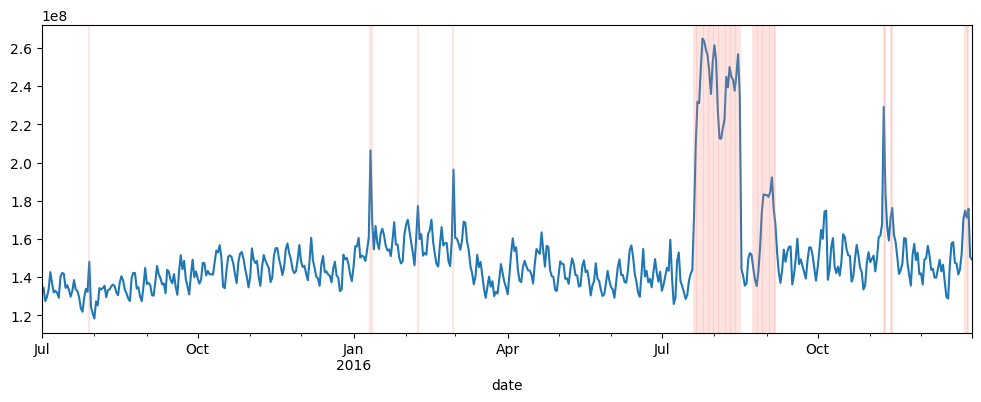

In [52]:
model_data.views.plot(figsize=(12,4))
for i,j in zip(model_data.Exog.index, model_data.Exog):
    if j:
        plt.axvline(x=i, color='#FA8072', alpha=0.2)

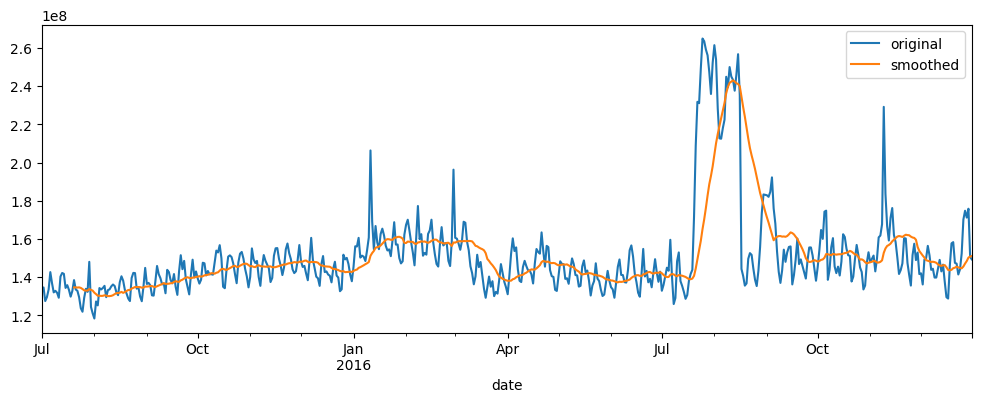

In [59]:
model_data.views.plot(label='original', figsize=(12,4))
model_data.views.rolling(20, center=False).mean().plot(label='smoothed')
plt.legend()

[]

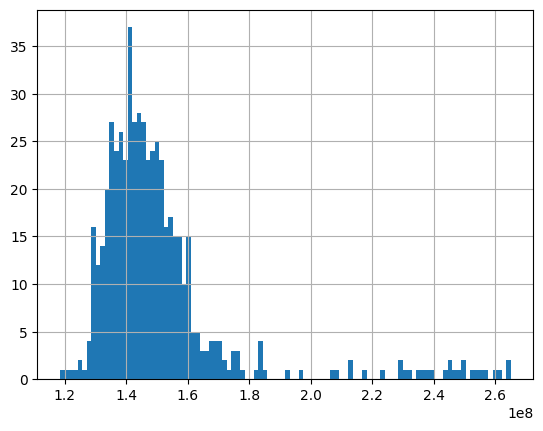

In [56]:
model_data.views.hist(bins=100).plot()

#### Dickey Fuller test for stationarity

In [55]:
sm.tsa.stattools.adfuller(model_data.views)[1]

0.01410493520278171

In [64]:
plt.rcParams['figure.figsize'] = (20, 6)

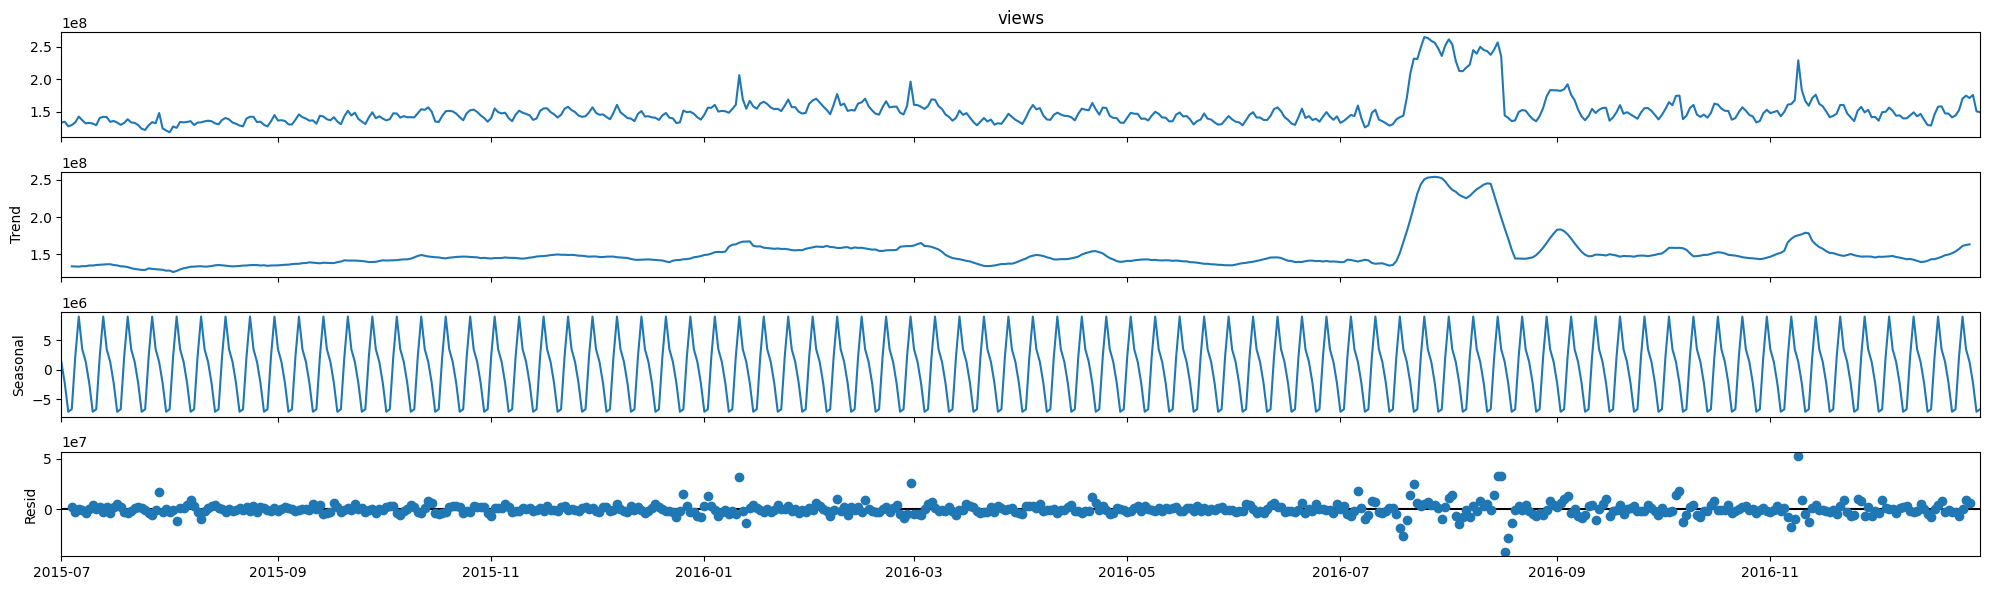

In [67]:
model = sm.tsa.seasonal_decompose(model_data.views, model='additive')
model.plot();

<Axes: xlabel='date'>

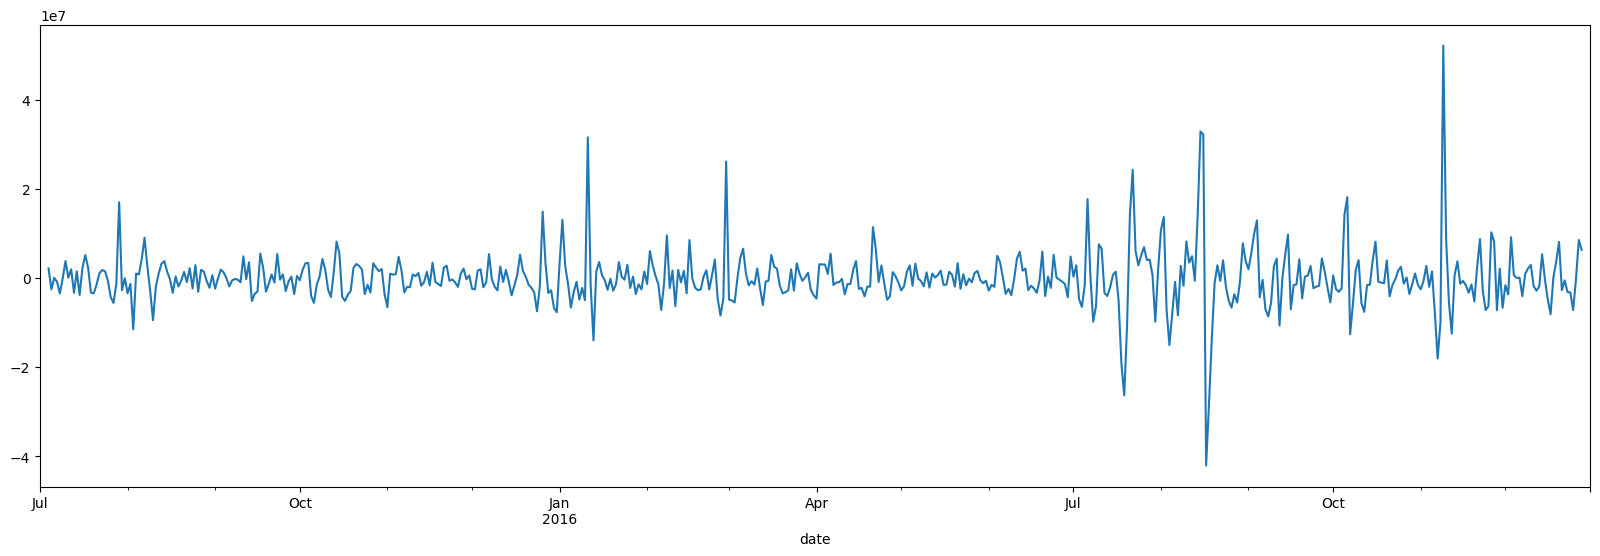

In [68]:
model.resid.plot()

[]

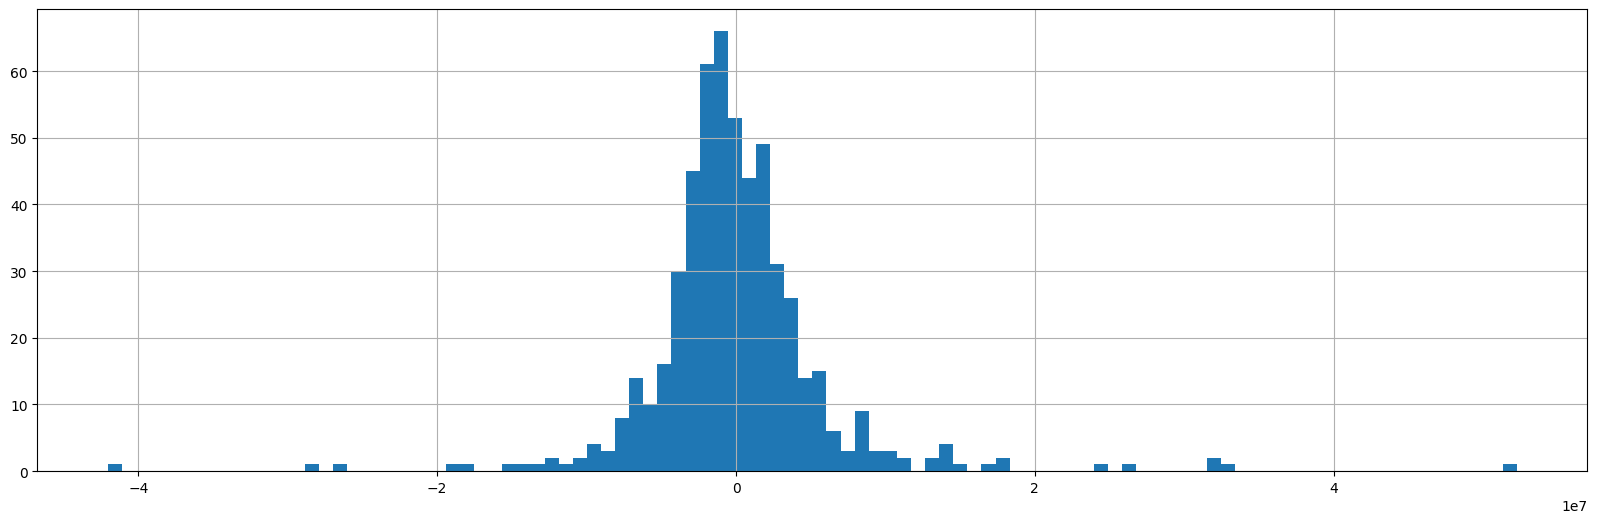

In [69]:
model.resid.hist(bins=100).plot()

In [79]:
sm.tsa.stattools.adfuller(model.resid.loc[~model.resid.isna()])[1]

1.0313551452533325e-19

<Axes: xlabel='date'>

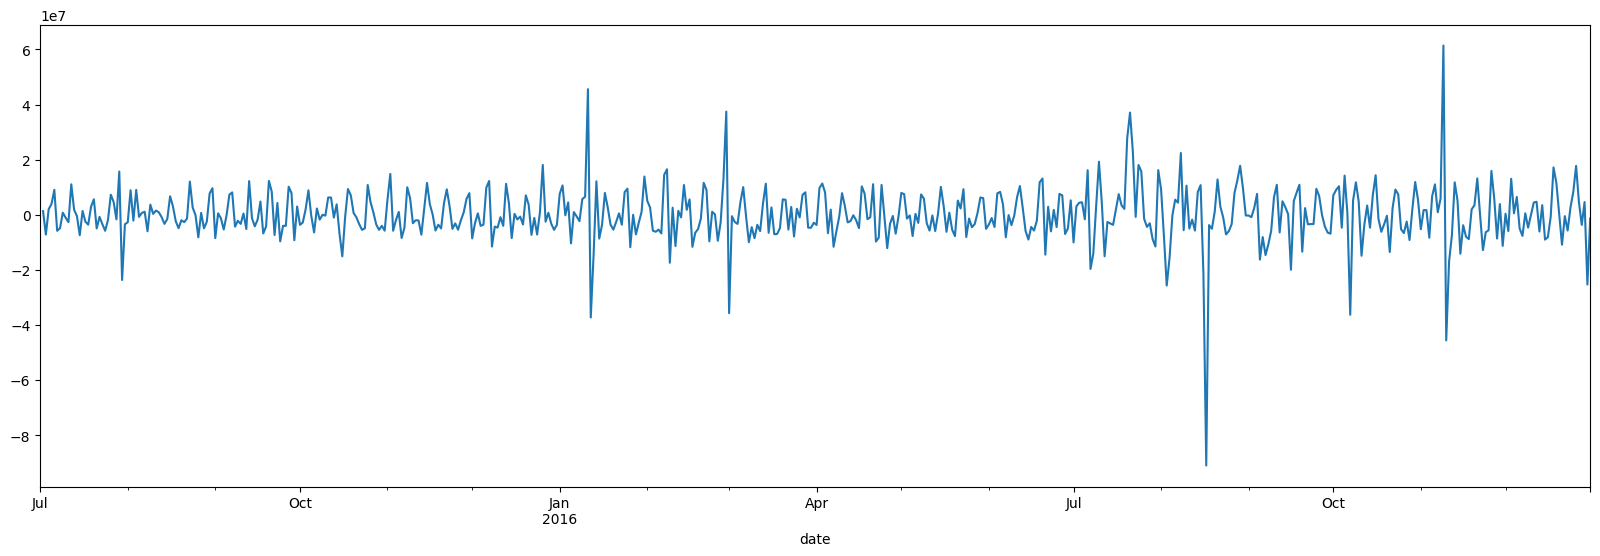

In [75]:
# detrending using differencing
detrend = model_data.views.diff()
detrend.plot()

In [82]:
sm.tsa.stattools.adfuller((detrend.loc[~detrend.isna()]))[1]

3.734608310472939e-11

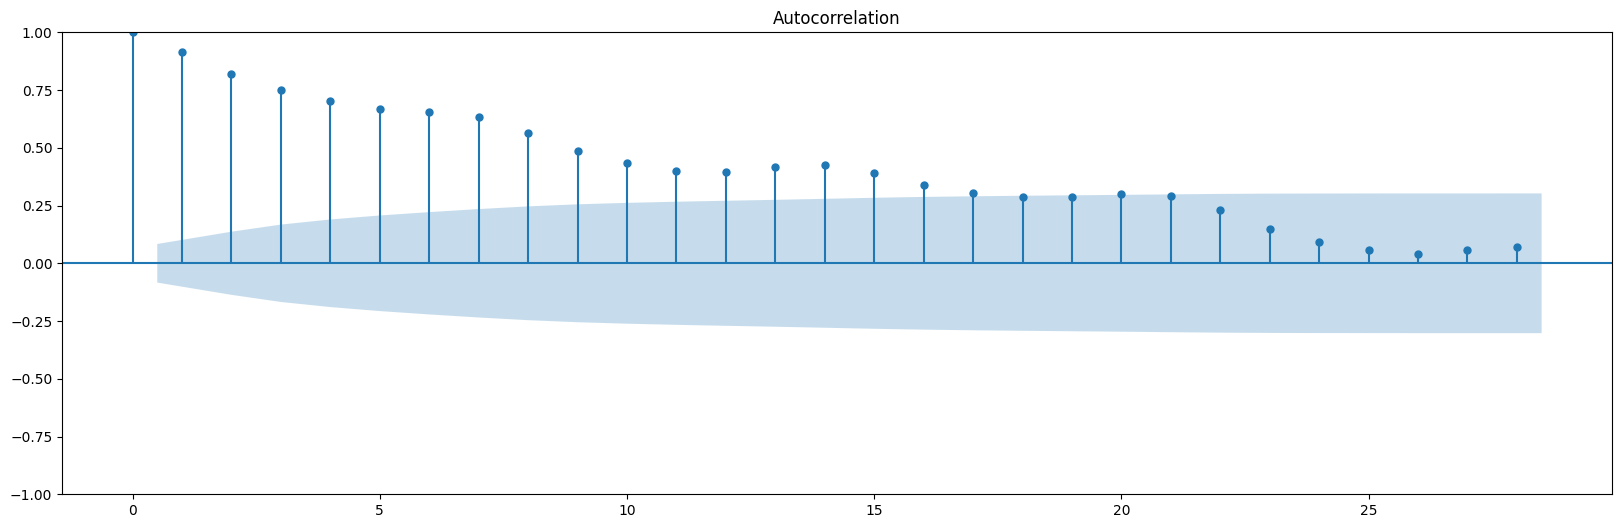

In [84]:
plot_acf(model_data.views);

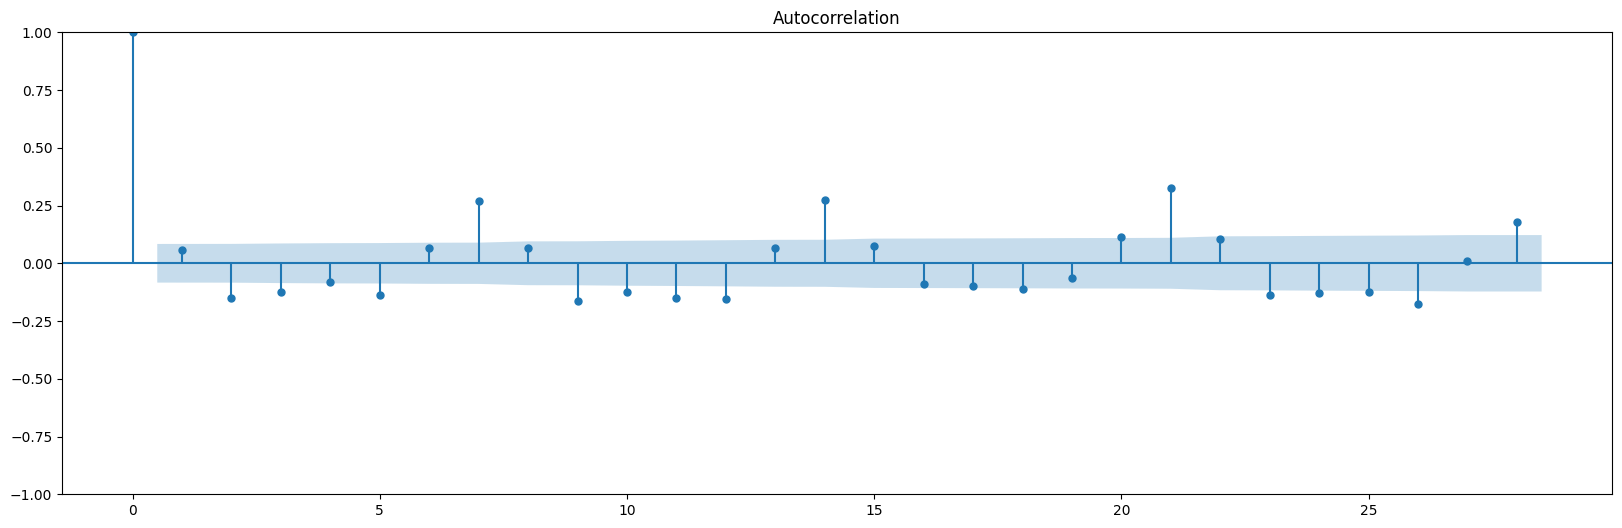

In [85]:
plot_acf(model_data.views.diff().dropna());

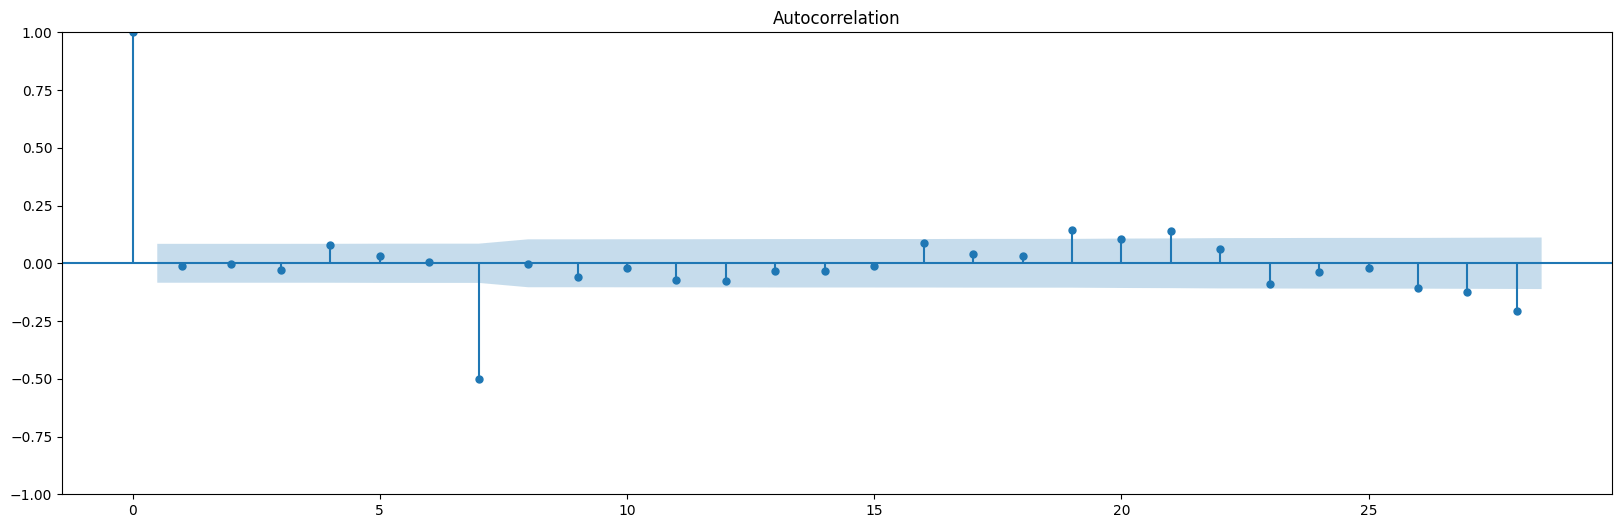

In [86]:
plot_acf(model_data.views.diff().diff(7).dropna());

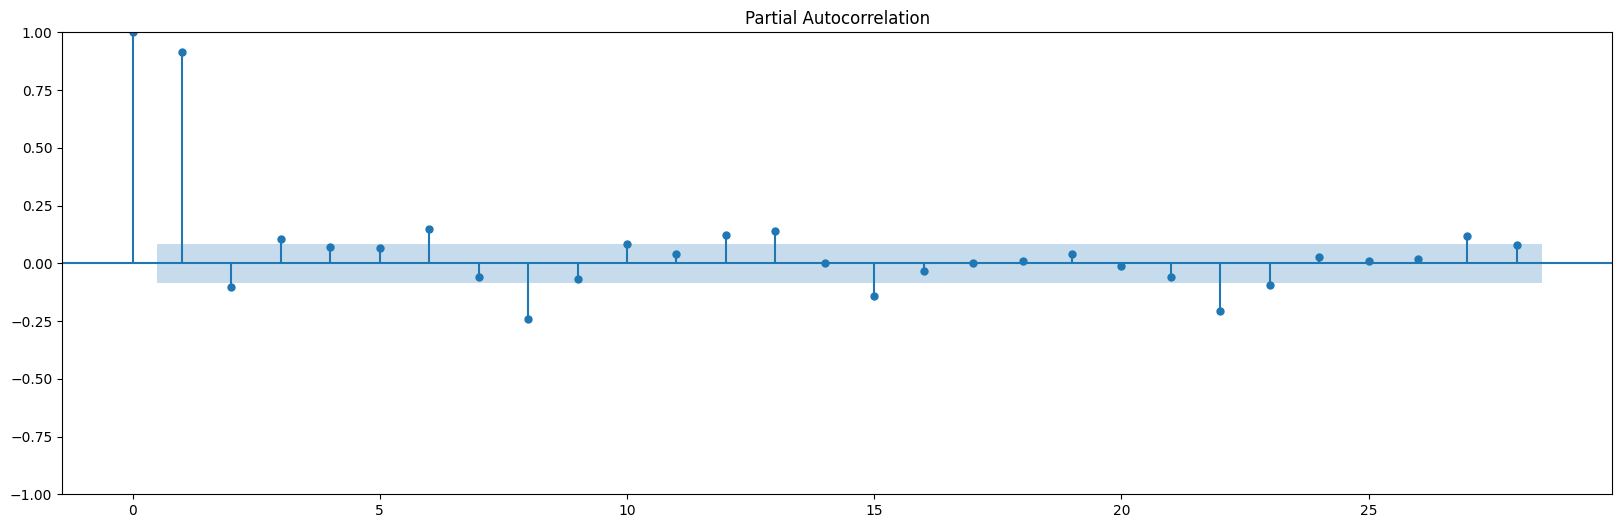

In [87]:
plot_pacf(model_data.views);

In [71]:
# train test split
model_data.shape[0]*0.15

82.5

In [72]:
train = model_data.loc[model_data.index < model_data.index[-82]].copy()
test = model_data.loc[model_data.index >= model_data.index[-82]].copy()

In [74]:
# Creating a function to print values of all the metrics
def performance(actual, predicted):
    print('MAE :', round(mae(actual, predicted), 3))
    print('RMSE :', round(mse(actual, predicted)**0.5, 3))
    print('MAPE:', round(mape(actual, predicted), 3))

### ARIMA model

/Users/gaurav.sharma/Downloads/Learning/time-series-analysis/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/gaurav.sharma/Downloads/Learning/time-series-analysis/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE : 9458104.404
RMSE : 13425220.779
MAPE: 0.061


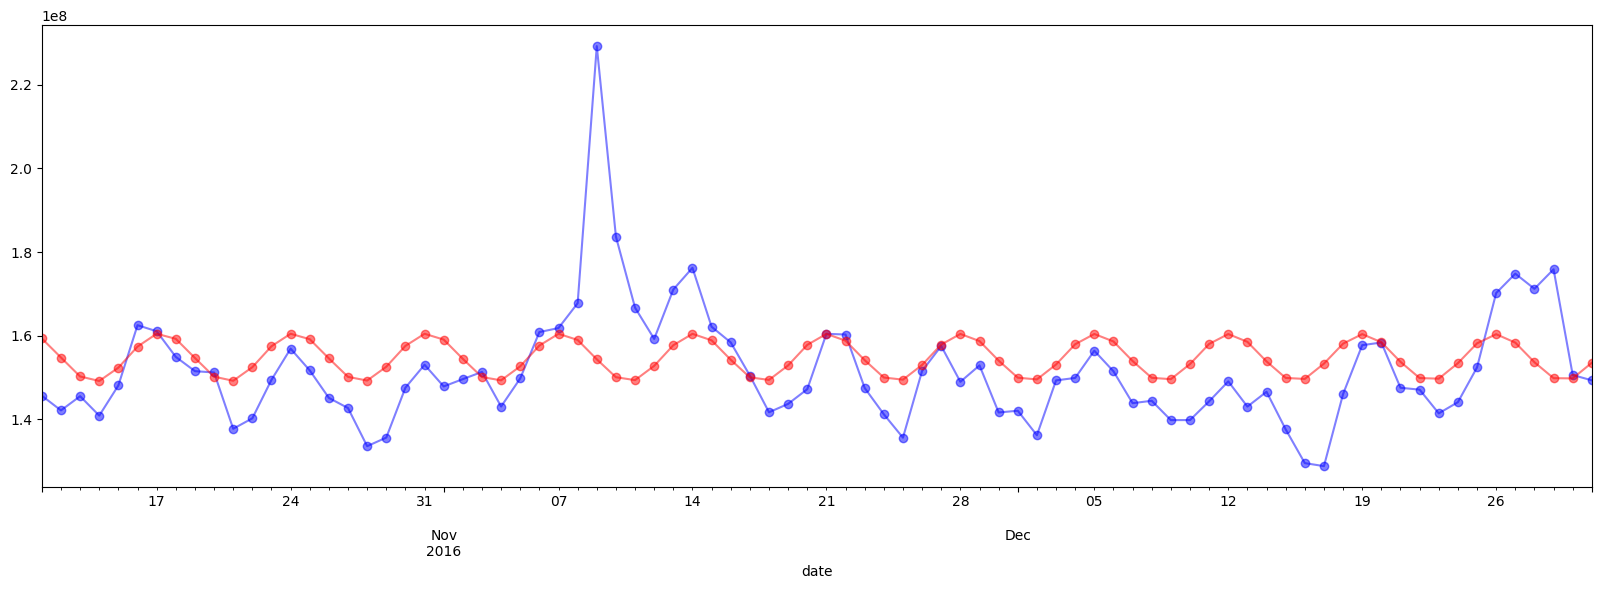

In [102]:
model = SARIMAX(train.views, order=(3, 1, 3))
model = model.fit(disp=False)
test['pred'] = model.forecast(steps=len(test))
test.views.plot(style='-o', color='blue', label='test_actual',alpha=0.5)
test.pred.plot(style='-o', color='red', label='predictions',alpha=0.5)
performance(test['views'], test['pred'])
plt.show()

/Users/gaurav.sharma/Downloads/Learning/time-series-analysis/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/gaurav.sharma/Downloads/Learning/time-series-analysis/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/gaurav.sharma/Downloads/Learning/time-series-analysis/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/gaurav.sharma/Downloads/Learning/time-series-analysis/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA param

MAE : 7785811.339
RMSE : 12782348.198
MAPE: 0.048


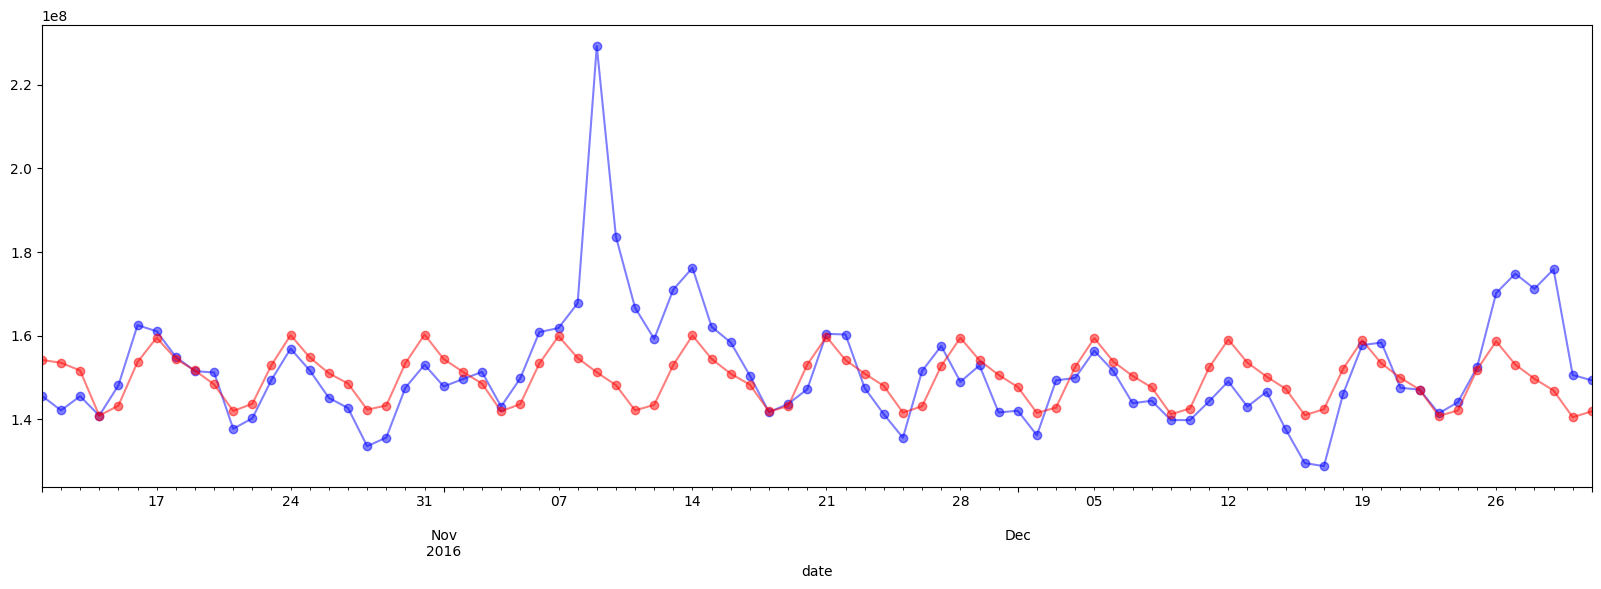

In [103]:
model = SARIMAX(train.views, order=(3, 1, 3), seasonal_order=(1,1,1,7))
model = model.fit(disp=False)
test['pred'] = model.forecast(steps=len(test))
test.views.plot(style='-o', color='blue', label='test_actual',alpha=0.5)
test.pred.plot(style='-o', color='red', label='predictions',alpha=0.5)
performance(test['views'], test['pred'])
plt.show()

/Users/gaurav.sharma/Downloads/Learning/time-series-analysis/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/gaurav.sharma/Downloads/Learning/time-series-analysis/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/gaurav.sharma/Downloads/Learning/time-series-analysis/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/gaurav.sharma/Downloads/Learning/time-series-analysis/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA param

MAE : 10934406.104
RMSE : 13189788.414
MAPE: 0.073


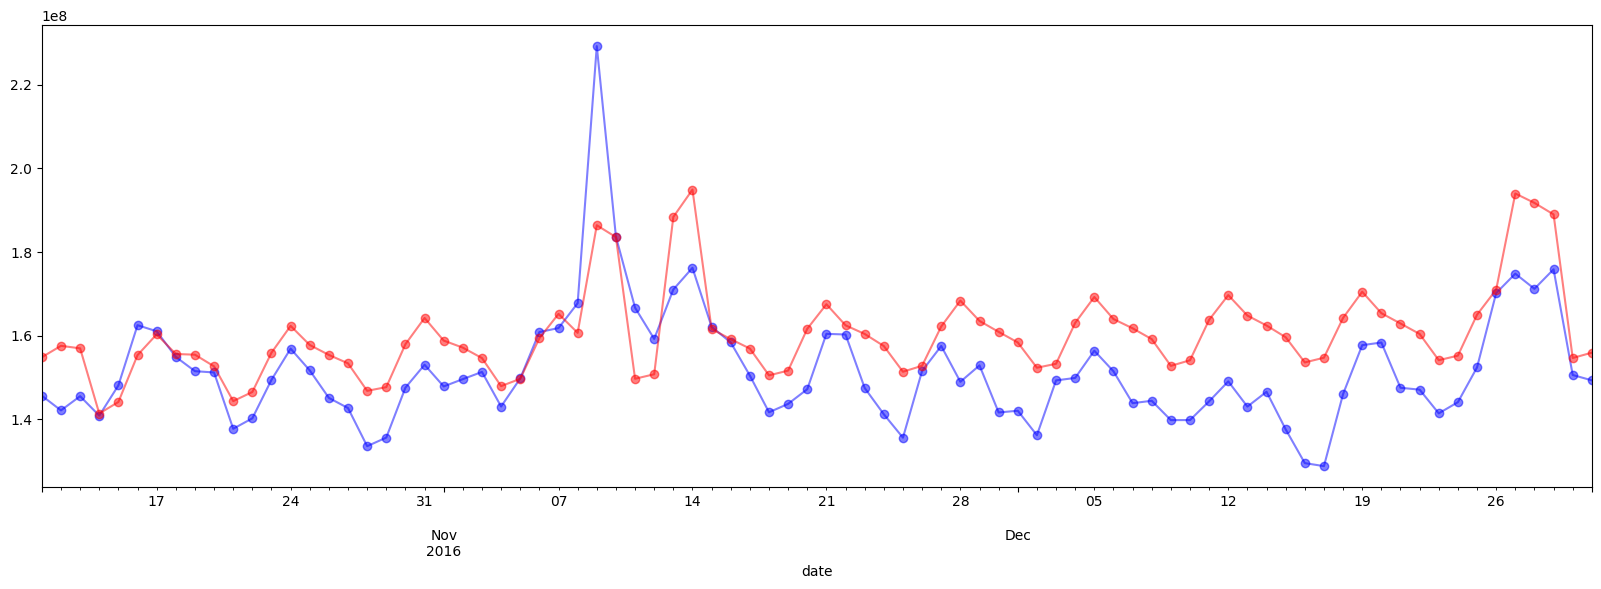

In [105]:

model = SARIMAX(train.views, order=(3, 1, 3), seasonal_order=(1,1,1,7), exog=train['Exog'])
model = model.fit(disp=False)
test_exog = test[['Exog']]
test['pred'] = model.forecast(steps=82, exog=test_exog)
test.views.plot(style='-o', color='blue', label='test_actual',alpha=0.5)
test.pred.plot(style='-o', color='red', label='predictions',alpha=0.5)
performance(test['views'], test['pred'])
plt.show()